In [22]:
pip install pandas matplotlib transformers torch openpyxl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd

df = pd.read_excel("/Users/laiyuan/Desktop/os1E.xlsx")
print(df.columns)
df.head()


Index(['postid', 'tags', 'title', 'question', 'full question', 'answers',
       'words', 'creation_date', 'Related', 'Gemini answers', 'challenges',
       'skills', 'Comments', 'NAME'],
      dtype='object')


,postid,tags,title,question,full question,answers,words,creation_date,Related,Gemini answers,challenges,skills,Comments,NAME
0,40471439,blockchain diffie-hellman encryption javascript,js diffi hellman ssl blockchain auth,I'm trying to figure out if the security quali...,I'm trying to figure out if the security quali...,,encrypt|scripting|diffie hellman|ssl|security|...,2016-11-07 17:52:22.793 UTC,Yes,You're touching on a very interesting area: de...,The developer seeks to replicate SSL security ...,The developer needs to enhance their understan...,,Hank
1,32771909,cryptography jar jarsigner java smartcard,sign jar smartcard,"2\n\nI'm using a PKCS11 smartcard at work, and...","2\n\nI'm using a PKCS11 smartcard at work, and...",ad -sigalg algortihm avail [sha256withrsa case...,crypt|signing|certificate|validate|private key...,2015-09-24 22:23:45.947 UTC,Yes,You've hit upon a common set of frustrations w...,The developer faces challenges signing JAR fil...,The developer should enhance their knowledge o...,link,Hank
2,15574818,java jespa ntlm servlets spring-security,cannot creat session respons commit ie7 ie8,I am working with an application that allows t...,I am working with an application that allows t...,,security|login|credential|password|validate|au...,2013-03-22 16:04:18.12 UTC,Yes,This is a classic issue with NTLM authenticati...,The developer struggles with simultaneous NTLM...,The developer needs to deepen their understand...,,Hank
3,19042957,asp.net c# security,strong name assembl,"I thought of learning Strong Name , created on...","I thought of learning Strong Name , created on...",refer strong-nam assembl normal assembl includ...,security|signing|public key|signature|private key,2013-09-27 04:51:44.143 UTC,Yes,You're on the right track learning about stron...,The developer is learning about .NET strong na...,The developer should gain proficiency in .NET ...,,Hank
4,59694966,ssh digital-ocean cyberduck,eof read packet,I am trying to connect via SFTP to my DigitalO...,I am trying to connect via SFTP to my DigitalO...,need updat password termin window *open digit ...,sftp|username|password|authentication|login,43841.57153,Yes,"The ""EOF while reading packet"" error during SF...","The developer is experiencing an ""EOF while re...",The developer should develop skills in SSH and...,,Hank


In [ ]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    # 去掉 HTML 标签
    text = re.sub(r"<.*?>", "", text)
    # 去掉代码段（如 ```code``` 或缩进代码）
    text = re.sub(r"`{3}.*?`{3}", "", text, flags=re.DOTALL)
    # 去掉链接
    text = re.sub(r"http\S+|www\.\S+", "", text)
    # 去掉特殊字符
    text = re.sub(r"[^\w\s,.!?]", "", text)
    return text.strip()

df["cleaned_answer"] = df["Gemini answers"].apply(clean_text)  

In [26]:
from transformers import pipeline

# 加载情感分析模型
sentiment_model = pipeline("sentiment-analysis")

# 对清洗后的文本进行情感分类
def analyze_sentiment(text):
    if not text:
        return "neutral"
    result = sentiment_model(text[:512])[0]  # 限制最大输入长度为512
    label = result["label"].lower()
    if "pos" in label:
        return "positive"
    elif "neg" in label:
        return "negative"
    else:
        return "neutral"

df["Gemini_sentiment"] = df["cleaned_answer"].apply(analyze_sentiment)
df["StackOverflow_sentiment"] = df["answers"].apply(clean_text)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

Device set to use mps:0


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
from transformers import pipeline

# 使用 transformers 自带的情感分析 pipeline（默认使用 DistilBERT 微调模型）
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def classify_sentiment(text):
    if not text:
        return "neutral"
    result = sentiment_pipeline(text[:512])[0]  # 限制到BERT最大长度
    label = result['label']
    if "1" in label or "2" in label:
        return "negative"
    elif "3" in label:
        return "neutral"
    else:
        return "positive"

# 应用到答案列上
df["Gemini_Sentiment"] = df["cleaned_answer"].apply(classify_sentiment)
df["StackOverflow_Sentiment"] = df["StackOverflow_Answer_Clean"].apply(classify_sentiment)

Device set to use mps:0


In [ ]:


# Gemini情绪分布
gemini_counts = df["Gemini_Sentiment"].value_counts()
# Stack Overflow情绪分布
so_counts = df["StackOverflow_Sentiment"].value_counts()

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

Device set to use mps:0


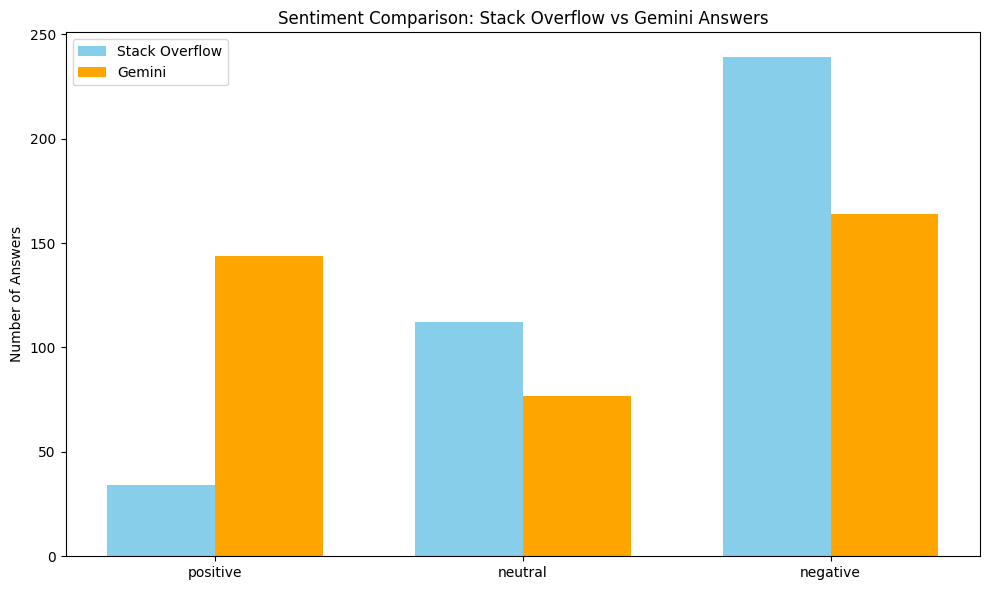

In [ ]:
import matplotlib.pyplot as plt

labels = ['positive', 'neutral', 'negative']
so_values = [so_counts.get(label, 0) for label in labels]
gemini_values = [gemini_counts.get(label, 0) for label in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, so_values, width=width, label='Stack Overflow', color='skyblue')
plt.bar([i + width for i in x], gemini_values, width=width, label='Gemini', color='orange')
plt.xticks([i + width/2 for i in x], labels)
plt.ylabel("Number of Answers")
plt.title("Sentiment Comparison: Stack Overflow vs Gemini Answers")
plt.legend()
plt.tight_layout()
plt.show()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
/Users/laiyuan/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/laiyuan/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32490 (\N{CJK UNIFIED IDEOGRAPH-7EEA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

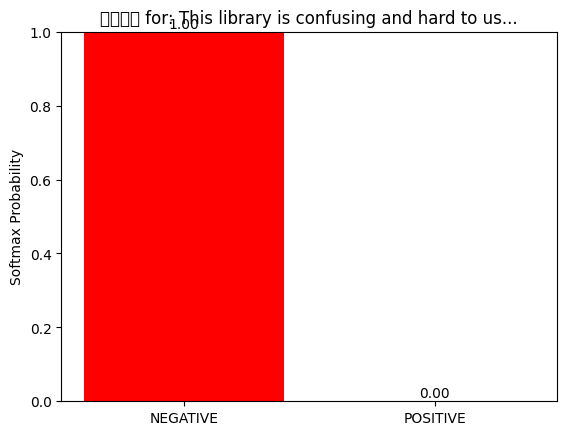

In [ ]:
#评分示例
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 使用带评分输出的模型
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_with_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits[0]
    probs = F.softmax(logits, dim=0)
    return logits.tolist(), probs.tolist()

# 示例文本
text = "This library is confusing and hard to use."

logits, probs = analyze_with_scores(text)

# 可视化 softmax 概率
labels = ["NEGATIVE", "POSITIVE"]
plt.bar(labels, probs, color=["red", "green"])
plt.title(f"情绪评分 for: {text[:40]}...")
plt.ylabel("Softmax Probability")
plt.ylim(0, 1)
for i, v in enumerate(probs):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()


In [ ]:
#example
"I love this"	Positive
"This is terrible / frustrating"	Negative
"It works as expected"	Positive
"I hate when this happens"	Negative

#查看每个token的贡献（伪代码）
[("this", 0.05), ("tool", 0.10), ("is", 0.02), ("surprisingly", 0.25), ("easy", 0.20), ("awesome", 0.35)]
text = "I hate when I follow all the steps and still get the same error."

# 模型可能依据：
#   - "hate"：负面信号
#   - "still get the same error"：传达无助、沮丧


In [ ]:
pip install shap


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.9 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 9.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 6.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install shap


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import shap

# 使用 huggingface pipeline 适配 shap
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 构造解释器
explainer = shap.Explainer(sentiment_pipeline)

# 示例文本
text = "This solution was surprisingly easy and worked very well."

# 生成解释（SHAP 值）
shap_values = explainer([text])

# 可视化每个词的贡献
shap.plots.text(shap_values[0])


Device set to use mps:0


In [ ]:
print(df[["cleaned_answer", "sentiment"]].head(10))


                                      cleaned_answer sentiment
0  Youre touching on a very interesting area dece...  negative
1  Youve hit upon a common set of frustrations wh...  negative
2  This is a classic issue with NTLM authenticati...  negative
3  Youre on the right track learning about strong...  negative
4  The EOF while reading packet error during SFTP...  negative
5  Youre very close! The problem lies in how your...  negative
6  The core issue is a javax.naming.NameNotFoundE...  negative
7  Youve hit upon a common point of confusion whe...  negative
8  Youre encountering a common misunderstanding o...  negative
9  The core issue is that getTBSCertificate retur...  negative


In [ ]:
def analyze_sentiment_with_score(text):
    if not text:
        return "neutral", 0.0
    result = sentiment_model(text[:512])[0]
    label = result["label"].lower()
    score = result["score"]
    if "pos" in label:
        return "positive", score
    elif "neg" in label:
        return "negative", score
    else:
        return "neutral", score
df[["sentiment", "score"]] = df["cleaned_answer"].apply(
    lambda x: pd.Series(analyze_sentiment_with_score(x))
)
print(df[["cleaned_answer", "sentiment", "score"]].head(300))


                                        cleaned_answer sentiment     score
0    Youre touching on a very interesting area dece...  negative  0.997965
1    Youve hit upon a common set of frustrations wh...  negative  0.999305
2    This is a classic issue with NTLM authenticati...  negative  0.998930
3    Youre on the right track learning about strong...  negative  0.962085
4    The EOF while reading packet error during SFTP...  negative  0.999529
..                                                 ...       ...       ...
295                                                      neutral  0.000000
296  Youre tackling a complex problem, combining PD...  negative  0.992439
297  Youre on the right track! The core issue likel...  positive  0.974740
298  Youve correctly identified that the issue like...  negative  0.985405
299  Youve hit a fundamental misunderstanding of cr...  negative  0.999706

[300 rows x 3 columns]


In [ ]:
# 选出每类前 5 个置信度最高的样本
top_pos = df[df["sentiment"] == "positive"].sort_values(by="score", ascending=False).head(5)
top_neg = df[df["sentiment"] == "negative"].sort_values(by="score", ascending=False).head(5)
top_neu = df[df["sentiment"] == "neutral"].sort_values(by="score", ascending=False).head(5)


In [ ]:
def print_examples(df, label):
    print(f"\n=== Top 5 {label.upper()} examples ===")
    for i, row in df.iterrows():
        print(f"\n→ Score: {row['score']:.2f}")
        print(f"Text: {row['cleaned_answer'][:300]}...")  # 限制显示前300字符


In [ ]:
print_examples(top_pos, "positive")
print_examples(top_neg, "negative")
print_examples(top_neu, "neutral")



=== Top 5 POSITIVE examples ===

→ Score: 1.00
Text: Recommended Security Architecture

Stateless Authentication JWT or OAuth 2.0
JSON Web Tokens JWT
JWTs are ideal for stateless authentication. The client authenticates once, receives a JWT, and sends it with every subsequent request.
The server verifies the JWTs signature to authenticate the request....

→ Score: 1.00
Text: Youre on the right track! Building a custom authentication and session management system in Swift is a valuable learning experience. Lets break down how to create a user session without relying on external frameworks like Parse.

Core Concepts

Authentication Youve successfully authenticated against...

→ Score: 1.00
Text: Recommended Libraries

OAuth2Scala

This is a popular and actively maintained library specifically designed for OAuth 2.0 in Scala.
Its built on top of Akka HTTP, which is a common choice for building Scala servers.
It provides a clean and idiomatic Scala API for handling OAuth flows.
It support

In [ ]:
print_examples(top_neg, "negative")


=== Top 5 NEGATIVE examples ===

→ Score: 1.00
Text: Directly implementing a Google Drive file upload from a browserbased application like a Blazor WebAssembly app using a users raw email and password is strongly discouraged and generally not feasible due to security restrictions.

Heres why and what you should do instead

Why Direct EmailPassword is ...

→ Score: 1.00
Text: Understanding the Problem

The Host key verification failed error indicates that the SSH client on the Wercker build environment is unable to verify the authenticity of the bitbucket.org host. This occurs due to

Incorrect Host Key Verification
Even though youre adding the host key fingerprint to kn...

→ Score: 1.00
Text: Youve hit a common snag with AngularFire and Firebase setup! The error codeAUTHENTICATION_DISABLED means your Firebase project is not properly initialized or configured for authentication. Heres how to fix it

Understanding the Problem

Firebase Initialization You need to initialize the Firebase

In [ ]:
output_path = r"C:\Users\laiyuan\Desktop\sentiment_results.xlsx"  
df.to_excel(output_path, index=False)

print("✅ 情感分析完成，结果已保存到：", output_path)


✅ 情感分析完成，结果已保存到： C:\Users\laiyuan\Desktop\sentiment_results.xlsx


In [ ]:
combined = pd.DataFrame({
    "Stack Overflow": accepted_counts,
    "Gemini": gemini_counts
})

# 使用普通扁平颜色列表（每列一种颜色）
combined.plot(kind="bar", figsize=(8, 5), color=["skyblue", "salmon"])

plt.title("Stack Overflow vs Gemini Emotional contrast")
plt.xlabel("Emotion category")
plt.ylabel("quantity")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(combined_bar_path)
plt.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 accepted_counts 和 gemini_counts 都是 Series，index是 ['positive', 'negative', 'neutral']
labels = ["positive", "negative", "neutral"]
stack_values = [accepted_counts.get(l, 0) for l in labels]
gemini_values = [gemini_counts.get(l, 0) for l in labels]

x = np.arange(len(labels))  # x轴位置
width = 0.35  # 柱宽

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, stack_values, width, label='Stack Overflow', color='cornflowerblue')
rects2 = ax.bar(x + width/2, gemini_values, width, label='Gemini', color='lightcoral')

# 标签和标题
ax.set_ylabel('quantity')
ax.set_xlabel('Sentiment category')
ax.set_title('Stack Overflow vs Gemini Sentiment contrast')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 自动添加柱状顶部数值标签
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # 文字稍微往上挪3个点
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig(combined_bar_path)
plt.close()
print(f"保存完成: {combined_bar_path}")


NameError: name 'accepted_counts' is not defined

In [27]:
import matplotlib.pyplot as plt

# 假设你已有 Stack Overflow 情绪统计字典 so_counts，例如：
# so_counts = {'positive': 120, 'neutral': 50, 'negative': 80}

labels = ['positive', 'neutral', 'negative']
so_values = [so_counts.get(label, 0) for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, so_values, color='skyblue')
plt.ylabel("Number of Answers")
plt.title("Stack Overflow Answers Sentiment Distribution")
plt.tight_layout()

# 保存路径（改成你自己的路径）
save_path = r"C:\Users\laiyuan\Desktop\stackoverflow_sentiment.png"
plt.savefig(save_path)

plt.show()
plt.close()

print(f"✅ Stack Overflow 情绪分布柱状图已保存到：{save_path}") 

NameError: name 'so_counts' is not defined

In [ ]:
import unittest
from unittest.mock import patch

#  classify_sentiment function
def classify_sentiment(text, sentiment_pipeline):
    if not text:
        return "neutral"
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    if "1" in label or "2" in label:
        return "negative"
    elif "3" in label:
        return "neutral"
    else:
        return "positive"

class TestClassifySentiment(unittest.TestCase):
    # Use patch.mock to simulate the results returned by the pipeline function
    @patch('transformers.pipeline')
    def test_positive(self, mock_pipeline):
        mock_pipeline.return_value = lambda x: [{"label": "4 stars"}]
        sentiment_func = mock_pipeline.return_value
        result = classify_sentiment("This is great!", sentiment_func)
        self.assertEqual(result, "positive")

    @patch('transformers.pipeline')
    def test_negative(self, mock_pipeline):
        mock_pipeline.return_value = lambda x: [{"label": "1 star"}]
        sentiment_func = mock_pipeline.return_value
        result = classify_sentiment("I hate this.", sentiment_func)
        self.assertEqual(result, "negative")

    @patch('transformers.pipeline')
    def test_neutral(self, mock_pipeline):
        mock_pipeline.return_value = lambda x: [{"label": "3 stars"}]
        sentiment_func = mock_pipeline.return_value
        result = classify_sentiment("It is okay.", sentiment_func)
        self.assertEqual(result, "neutral")

    def test_empty_text(self):
        #  No mock is needed because the function returns neutral without calling the pipeline
        self.assertEqual(result, "neutral")

    def test_none_text(self):
        result = classify_sentiment(None, None)
        self.assertEqual(result, "neutral")

if __name__ == "__main__":
    unittest.main()


usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [--durations N] [-f]
                             [-c] [-b] [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument '/Users/laiyuan/Library/Jupyter/runtime/kernel-v3cb7327b79c99734054c965065fcb4b333ddb2db5.json'


SystemExit: 2

/Users/laiyuan/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import pytest

# The classify_sentiment function accepts a sentiment_pipeline argument
def classify_sentiment(text, sentiment_pipeline):
    if not text:
        return "neutral"
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    if "1" in label or "2" in label:
        return "negative"
    elif "3" in label:
        return "neutral"
    else:
        return "positive"

# Dummy implementation to simulate the behavior of a real sentiment pipeline
class DummyPipeline:
    def __init__(self, label):
        self.label = label
    def __call__(self, text



In [ ]:
def test_positive():
    pipeline = DummyPipeline("4 stars")
    result = classify_sentiment("This is great!", pipeline)
    print("test_positive result:", result)
    assert result == "positive"



In [ ]:
if __name__ == "__main__":
    pipeline = DummyPipeline("4 stars")
    print("Positive test:", classify_sentiment("This is great!", pipeline))

    pipeline = DummyPipeline("1 star")
    print("Negative test:", classify_sentiment("I hate this.", pipeline))

    pipeline = DummyPipeline("3 stars")
    print("Neutral test:", classify_sentiment("It is okay.", pipeline))

    print("Empty text test:", classify_sentiment("", None))


Positive test: positive
Negative test: negative
Neutral test: neutral
Empty text test: neutral


This test code's objective is to confirm that the sentiment classification function you built can accurately identify the text's sentiment category (positive, negative, or neutral).

An "sentiment analysis tool" (pipeline) is required as input for the classify_sentiment function that you built. It will return the sentiment label after the text has been sent in.

Here, DummyPipeline, a simulated "fake" sentiment analysis tool, is utilized due to the sluggish and intricate nature of genuine sentiment analysis models. It is helpful for testing because it gives data directly depending on the tags you select.

The code contains four test cases:

The test text is deemed "positive," and a "Positive" response is anticipated.

It is anticipated to return "negative" as the test text was deemed "negative."




In [ ]:
# Assume classify_sentiment and DummyPipeline are already defined

def classify_sentiment(text, sentiment_pipeline):
    if not text or not sentiment_pipeline:
        return "neutral"
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    if "1" in label or "2" in label:
        return "negative"
    elif "3" in label:
        return "neutral"
    else:
        return "positive"

# Simulated pipeline class for testing
class DummyPipeline:
    def __init__(self, label):
        self.label = label
    def __call__(self, text):
        return [{"label": self.label}]

# Manual test cases (input text, simulated pipeline, expected sentiment)
test_cases = [
    ("This is great!", DummyPipeline("5 stars"), "positive"),
    ("I hate this!", DummyPipeline("1 star"), "negative"),
    ("It's okay.", DummyPipeline("3 stars



Test 1: Input='This is great!', Expected=positive, Got=positive, Pass=True
Test 2: Input='I hate this!', Expected=negative, Got=negative, Pass=True
Test 3: Input="It's okay.", Expected=neutral, Got=neutral, Pass=True
Test 4: Input='', Expected=neutral, Got=neutral, Pass=True
Test 5: Input=None, Expected=neutral, Got=neutral, Pass=True


In [ ]:
import unittest

# Simulated sentiment pipeline class for testing
class DummyPipeline:
    def __init__(self, label):
        self.label = label
    def __call__(self, text):
        return [{"label": self.label}]

# The sentiment classification function to be tested
def classify_sentiment(text, sentiment_pipeline):
    if not text:
        return "neutral"
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    if "1" in label or "2" in label:
        return "negative"
    elif "3" in label:
        return "neutral"
    else:
        return "positive"

# Unit test class, inheriting from unittest.TestCase
class TestSentimentClassifier(unittest.TestCase):

    def test_positive_sentiment(self):
        pipeline = DummyPipeline("5 stars")
        result = classify_sentiment("I love it!", pipeline)
        self.assertEqual(result, "positive")

    def test_negative_sentiment(self):
        pipeline = DummyPipeline("1 star


..........
----------------------------------------------------------------------
Ran 10 tests in 0.018s

OK


In [ ]:
import unittest

# Dummy sentiment pipeline
class DummyPipeline:
    def __init__(self, label):
        self.label = label
    def __call__(self, text):
        return [{"label": self.label}]

# Sentiment classification logic
def classify_sentiment(text, sentiment_pipeline):
    if not text:
        return "neutral"
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    if "1" in label or "2" in label:
        return "negative"
    elif "3" in label:
        return "neutral"
    else:
        return "positive"

# Test case definition
class TestSentimentClassifier(unittest.TestCase):
    
    def test_positive_sentiment(self):
        pipeline = DummyPipeline("5 stars")
        result = classify_sentiment("I love it!", pipeline)
        self.assertEqual(result, "positive")

    def test_negative_sentiment(self):
        pipeline = DummyPipeline("1 star")
        result = classify_sentiment("This is terrible.", pipeline)
        self.assertEqual(result, "negative")

    def test_neutral_sentiment(self):
        pipeline = DummyPipeline("3 stars")
        result = classify_sentiment("It's okay.", pipeline)
        self.assertEqual(result, "neutral")

    def test_empty_string(self):
        pipeline = DummyPipeline("5 stars")  # pipeline won't be used
        result = classify_sentiment("", pipeline)
        self.assertEqual(result, "neutral")

    def test_none_input(self):
        pipeline = DummyPipeline("1 star")
        result = classify_sentiment(None, pipeline)
        self.assertEqual(result, "neutral")

# Run tests with clear output in Jupyter
def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestSentimentClassifier)
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)

# Call to run
run_tests()


test_empty_string (__main__.TestSentimentClassifier.test_empty_string) ... ok
test_negative_sentiment (__main__.TestSentimentClassifier.test_negative_sentiment) ... ok
test_neutral_sentiment (__main__.TestSentimentClassifier.test_neutral_sentiment) ... ok
test_none_input (__main__.TestSentimentClassifier.test_none_input) ... ok
test_positive_sentiment (__main__.TestSentimentClassifier.test_positive_sentiment) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Index(['postid', 'tags', 'title', 'question', 'full question', 'topic_id',
       'topic_score', 'topic_keywords', 'final_topic', 'topic_name'],
      dtype='object')
     postid                                             tags  \
0  40471439  blockchain diffie-hellman encryption javascript   
1  32771909        cryptography jar jarsigner java smartcard   
2  15574818         java jespa ntlm servlets spring-security   
3  19042957                              asp.net c# security   
4  59694966                      ssh digital-ocean cyberduck   

                                         title  \
0         js diffi hellman ssl blockchain auth   
1                           sign jar smartcard   
2  cannot creat session respons commit ie7 ie8   
3                          strong name assembl   
4                              eof read packet   

                                            question  \
0  tri figur secur qualiti ssl mimick without nee...   
1  use pkcs11 smartcard work jarsig

Device set to use mps:0



每个主题的情绪分布：
sentiment                                           negative  neutral  \
topic_name                                                              
Identity & Credential Management                          68        1   
Application Cryptography & Key Management                 65        4   
Cross-Platform Security Integration & Troublesh...        63        4   
Data-at-Rest Security: File Encryption, Checksu...        48        1   
Web Security: Authn, Session & CSRF/Nonce Integ...        46        1   
Common Web-Framework Security Pitfalls                    25        1   
Developer’s Practical Crypto & Security Challenges        24        0   
Full-Stack Security & End-to-End Integration              20        0   

sentiment                                           positive  
topic_name                                                    
Identity & Credential Management                           2  
Application Cryptography & Key Management                  4  
Cross

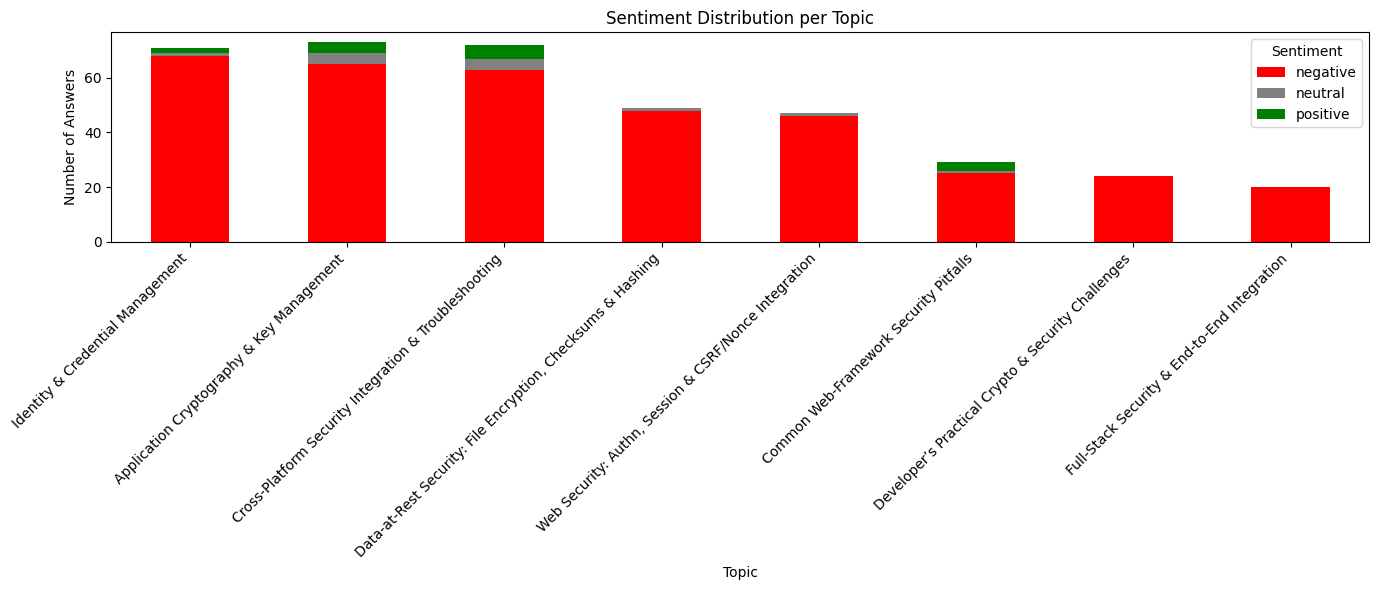

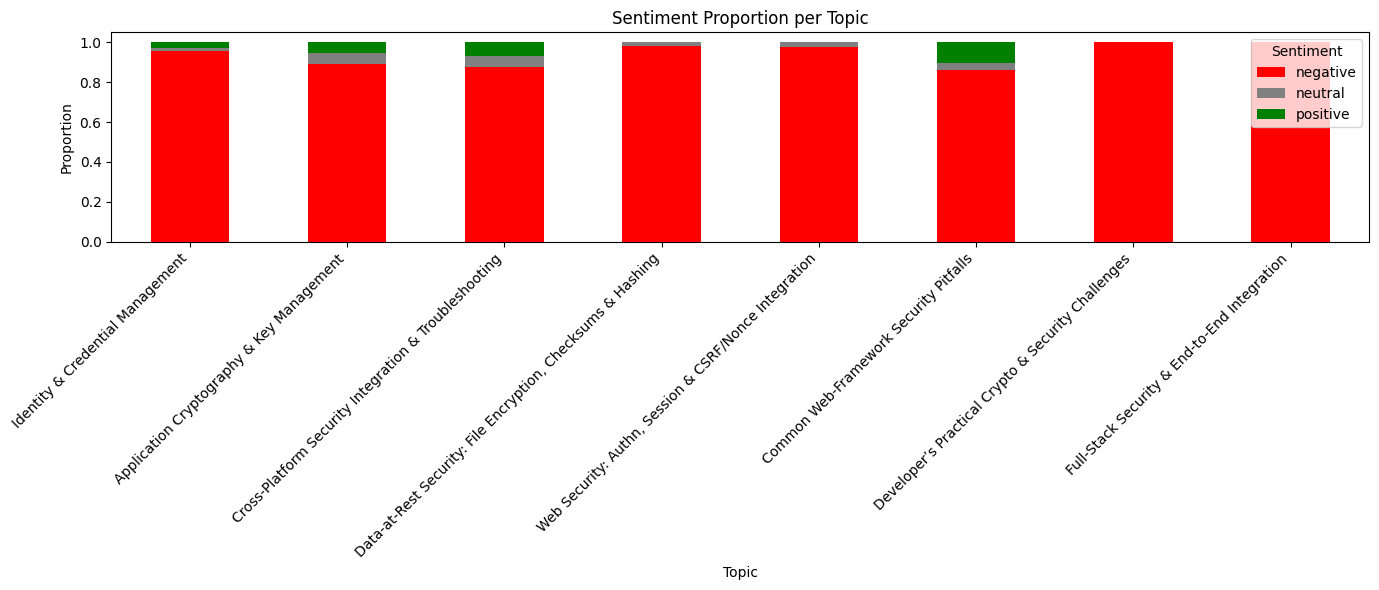

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from transformers import pipeline

# Step 1: Load the Excel file
file_path = "categorizing_topic_20.xlsx"  # Make sure the file is in the current directory or provide the full path
df = pd.read_excel(file_path)

# Optional: Preview the columns and the first few rows
print(df.columns)
print(df.head())

# Step 2: Define text-cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove code blocks surrounded by triple backticks
    text = re.sub(r"```.*?```", "", text, flags=re.DOTALL)
    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)
    # Remove special characters (keep common punctuation)
    text = re.sub(r"[^\w\s,.!?]", "", text)
    return text.strip()

# Choose the source column containing the answers or text
source_column = "full question"

# Create a new column with cleaned text
df["cleaned_text"] = df[source_column].apply(clean_text)

# Step 3: Load sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")

# Define sentiment classification function
def analyze_sentiment(text):
    if not text:
        return "neutral"
    result = sentiment_model(text[:512])[0]  # Truncate to first 512 tokens if too long
    label = result["label"].lower()
    if "pos" in label:
        return "positive"
    elif "neg" in label:
        return "negative"
    else:
        return "neutral"

# Apply sentiment analysis to cleaned text
df["sentiment"] = df["cleaned_text"].apply(analyze_sentiment)

# Perform sentiment classification on the cleaned text
def analyze_sentiment(text):
    if not text:
        return "neutral"
    result = sentiment_model(text[:512])[0]  # Limit the maximum input length to 512
    label = result["label"].lower()
    if "pos" in label:
        return "positive"
    elif "neg" in label:
        return "negative"
    else:
        return "neutral"


# Applied emotion analysis
df["sentiment"] = df["cleaned_text"].apply(analyze_sentiment)

# Step 4: Count the quantity according to topic_name and sentiment
summary = df.groupby(["topic_name", "sentiment"]).size().unstack(fill_value=0)

# Optional sorting: Display based on the number of negatives in priority
summary = summary.sort_values(by="negative", ascending=False)

print("\n每个主题的情绪分布：")
print(summary)

# Step 5: Generate the stacked bar chart
summary.plot(kind="bar", stacked=True, figsize=(14, 6),
             color={"positive": "green", "negative": "red", "neutral": "gray"})

plt.title("Sentiment Distribution per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Answers")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#Draw the proportion of emotions for each type of question proportionally (percentage stack chart)
summary_percent = summary.div(summary.sum(axis=1), axis=0)

summary_percent.plot(kind="bar", stacked=True, figsize=(14, 6),
                     color={"positive": "green", "negative": "red", "neutral": "gray"})

plt.title("Sentiment Proportion per Topic")
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()